# Data Validation with Pandera

In [12]:
import pandas as pd
import pandera as pa
from pandera.typing import Series

class SalesSchema(pa.DataFrameModel):
    item_id: Series[str] = pa.Field(coerce=True)
    date: Series[pd.Timestamp] = pa.Field(coerce=True)
    sales: Series[float] = pa.Field(ge=0, nullable=False) # ge=0: Greater than or equal to 0

    # Custom check: ensure dates are monotonic increasing
    @pa.check("date")
    def check_date_order(cls, series: Series) -> bool:
        return series.is_monotonic_increasing

# 2. Simulate Data
good_data = pd.DataFrame({
    "item_id": ["A", "A", "A"],
    "date": ["2023-01-01", "2023-01-02", "2023-01-03"],
    "sales": [100.0, 120.0, 110.0]
})

bad_data = pd.DataFrame({
    "item_id": ["A", "A", "A"],
    "date": ["2023-01-01", "2023-01-02", "2023-01-03"],
    "sales": [100.0, -50.0, 110.0] # <--- Invalid negative sales
})

# 3. Validate
print("Validating Good Data...")
try:
    # In DataFrameModel, we use the validate class method or call the class directly
    SalesSchema.validate(good_data)
    print("✅ Good Data Passed!")
except pa.errors.SchemaError as e:
    print(e)

print("\nValidating Bad Data...")
try:
    SalesSchema.validate(bad_data)
except pa.errors.SchemaError as e:
    print(f"❌ Bad Data Caught! Error: {e.failure_cases}")


Validating Good Data...
✅ Good Data Passed!

Validating Bad Data...
❌ Bad Data Caught! Error:    index  failure_case
0      1         -50.0


# Point-in-Time Correctness (Simulated Feature Store)

In [13]:
# This mimics the "AS OF" join discussed in the chapter

sales_events = pd.DataFrame({
    "event_id": [1, 2],
    "timestamp": pd.to_datetime(["2023-01-01 09:00:00", "2023-01-01 15:00:00"]),
    "sales": [100, 200]
}).sort_values("timestamp")

weather_updates = pd.DataFrame({
    "timestamp": pd.to_datetime(["2023-01-01 08:00:00", "2023-01-01 12:00:00", "2023-01-01 16:00:00"]),
    "temperature": [20, 25, 18]
}).sort_values("timestamp")

print("\n--- Point-in-Time Join (AS OF) ---")
# merge_asof is the pandas equivalent to Feature Store retrieval [cite: 179]
pit_data = pd.merge_asof(
    sales_events,
    weather_updates,
    on="timestamp",
    direction="backward" # Crucial: Look backwards in time only
)

print(pit_data)


--- Point-in-Time Join (AS OF) ---
   event_id           timestamp  sales  temperature
0         1 2023-01-01 09:00:00    100           20
1         2 2023-01-01 15:00:00    200           25


# Censored Data Correction (XGBoost AFT)


--- Censored Data Correction Results ---
Average Observed Sales (Biased): 41.44
Average Predicted Demand (AFT):  47.09
True Average Demand:             45.05


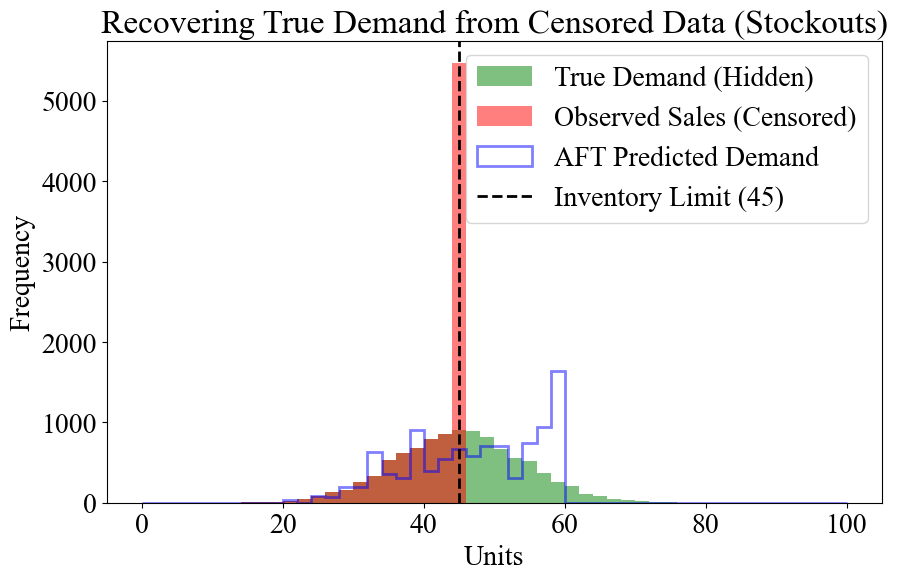

In [14]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

# 1. Simulate Data (Stronger Signal)
np.random.seed(42)
N = 10000

# Feature X: Marketing Spend (Mean=3, Std=1.5)
X = np.random.normal(3, 1.5, size=(N, 1))

# True Demand = 30 + 5 * X (Stronger Linear relationship)
# Mean True Demand approx 45.
true_demand = np.maximum(0, 30 + 5 * X[:, 0] + np.random.normal(0, 5, N))

# Inventory Limit (Censoring Point)
inventory_limit = 45
sales = np.minimum(true_demand, inventory_limit)
is_censored = true_demand > inventory_limit

# 2. Prepare Data for AFT
y_lower = np.log(sales + 1e-5) 
# Upper bound: 2x Inventory (log(90)). 
# This tells the model: "If stockout, demand was between 45 and 90".
y_upper = np.where(is_censored, np.log(90), y_lower)

dtrain = xgb.DMatrix(X)
dtrain.set_float_info('label_lower_bound', y_lower)
dtrain.set_float_info('label_upper_bound', y_upper)

# 3. Train AFT Model
params = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal', 
    'learning_rate': 0.05, 
    'max_depth': 3,
}

# Train enough to capture the trend (100 rounds)
model = xgb.train(params, dtrain, num_boost_round=100)

# 4. Predict
log_preds = model.predict(dtrain)
preds = np.exp(log_preds)

print(f"\n--- Censored Data Correction Results ---")
print(f"Average Observed Sales (Biased): {sales.mean():.2f}")
print(f"Average Predicted Demand (AFT):  {preds.mean():.2f}")
print(f"True Average Demand:             {true_demand.mean():.2f}")

# 5. Visualization
plt.figure(figsize=(10, 6))
plt.hist(true_demand, bins=50, range=(0, 100), alpha=0.5, label='True Demand (Hidden)', color='green')
plt.hist(sales, bins=50, range=(0, 100), alpha=0.5, label='Observed Sales (Censored)', color='red')
plt.hist(preds, bins=50, range=(0, 100), alpha=0.5, label='AFT Predicted Demand', color='blue', histtype='step', linewidth=2)

plt.axvline(inventory_limit, color='k', linestyle='--', label='Inventory Limit (45)')
plt.title("Recovering True Demand from Censored Data (Stockouts)")
plt.xlabel("Units")
plt.ylabel("Frequency")
plt.legend()
plt.show()